In [2]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
import torch

2023-10-20 14:48:14.478355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 14:48:17.168644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
def json_to_dataframe(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.iloc[0])
    f.close()
    df["headline"]= df.apply(lambda x: x['masked headline'].replace('____', str(x['ans'])), axis=1)
    print(df.iloc[0])
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
    df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
    df = df.astype(str)
    return df

In [6]:
train_data = json_to_dataframe('Train_Numerical_Reasoning.json')

news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object
news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
headline            30K Walmart Part-Timers to Lose Health Insurance
Name: 0, dtype: object


In [7]:
train_data.head()

news  \
0   As of Jan. 1, Walmart will no longer offer 30...   
1   Dax Shepard and Kristen Bell got married at t...   
2   Nancy Reagan, the helpmate, backstage adviser...   
3   American Airlines faces FAA fines of more tha...   
4   Ingrid Lyne, the Seattle mom allegedly murder...   

                                     masked headline            calculation  \
0  <extra_id_0> K Walmart Part-Timers to Lose Hea...   Paraphrase(30,000,K)   
1  Dax Shepard: Wedding to Kristen Bell Cost $<ex...              Copy(142)   
2            Nancy Reagan Dead at <extra_id_0>  </s>               Copy(94)   
3  American Airlines Faces $<extra_id_0> M Fine f...                Copy(7)   
4  $<extra_id_0> K Raised for Kids of Mom Dismemb...  Paraphrase(222,000,K)   

   ans                                           headline  \
0   30   30K Walmart Part-Timers to Lose Health Insurance   
1  142     Dax Shepard: Wedding to Kristen Bell Cost $142   
2   94                            Nancy Reagan Dead at 94   
3    7  American Airlines Faces $7M Fine for Safety Vi...   
4  222   $222K Raised for Kids of Mom Dismembered on Date   

                                                text  
0   As of Jan. 1, Walmart will no longer offer 30...  
1   Dax Shepard and Kristen Bell got married at t...  
2   Nancy Reagan, the helpmate, backstage adviser...  
3   American Airlines faces FAA fines of more tha...  
4   Ingrid Lyne, the Seattle mom allegedly murder...

In [8]:
dataset = Dataset.from_pandas(train_data)
dataset = dataset.train_test_split(test_size=0.2)

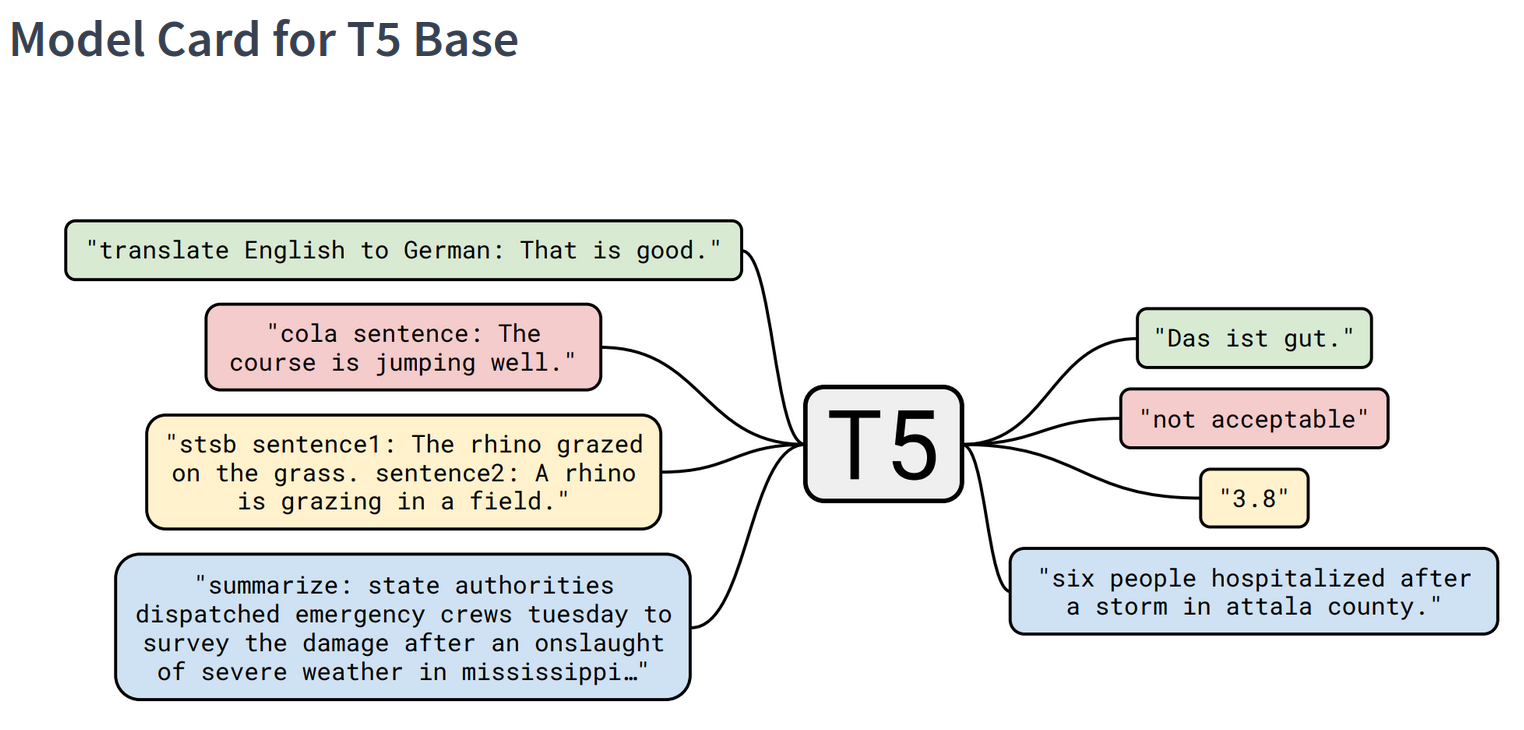

T5 is Text-to-Text-Transfer-Transformer model. It takes input texts for various NLP tasks and outputs the text for that respective task. 

T5 is slightly different from Masked Language Model such as BERT. Masked Language Models are Bidirectional models which use Mask token for each word while T5 replaces multiple consecutive tokens with a single Mask keyword. Since the final objective is to have trained a model that inputs text and outputs text, the targets were designed to produce a sequence, unlike BERT, that tries to output one word (itself). So t5 is suitable for text summarization and headline generation.

In [9]:
model_name = "Michau/t5-base-en-generate-headline"

### The model is based on t5-base and has been trained on a collection of 500k articles with headings. Its purpose is to create a one-line heading suitable for the given article. https://huggingface.co/Michau/t5-base-en-generate-headline

To prefix the input with a prompt so T5 knows this is a headline generation task

In [10]:
def preprocess_function(examples):   
    #inputs = [prefix + doc for doc in examples["news"]]
    inputs = tokenizer(examples['text'],max_length=2024,  truncation=True)
    labels = tokenizer(text_target=examples["headline"], max_length=128, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

To apply the preprocess function over the entire dataset

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [12]:
tokenized = dataset.map(preprocess_function, batched=True, num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map (num_proc=4):   0%|          | 0/16925 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4232 [00:00<?, ? examples/s]

In [10]:
#tokenized = train_data.map(preprocess_function, batched=True)

To create batches using DataCollatorForSeq2Seq, which dynamically pads the sentences to the longest length in a batch during collation. This is  more efficient than padding the whole dataset to the maximum length. 

In [13]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
#optimizer = AdamWeightDecay(learning_rate=1e-4, weight_decay_rate=0.01)
optimizer = AdamWeightDecay(learning_rate=7e-5, weight_decay_rate=0.01)
#optimizer = AdamWeightDecay(learning_rate=8e-5, weight_decay_rate=0.01)

To load pretrained T5-base michau with AutoModelForSeq2SeqLM

In [14]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

2023-10-20 14:48:38.818270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30315 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2023-10-20 14:48:38.819181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30835 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:c1:00.0, compute capability: 7.0
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Michau/t5-base-en-generate-headline.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


To convert datasets to the tf.data.Dataset format 

In [15]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [16]:
model.compile(optimizer=optimizer)

In [17]:
eval_loss = model.evaluate(tf_test_set)
print(f"Pretrained LM Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 61s 199ms/step - loss: 0.9788
Pretrained LM Perplexity: 2.66


In [18]:
history = model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size =6, epochs=3)
#model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=1)
#eval_loss = model.evaluate(tf_test_set)
#print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

Epoch 1/3
1057/1057 [==============================] - 668s 612ms/step - loss: 0.0834 - val_loss: 0.0466
Epoch 2/3
1057/1057 [==============================] - 648s 613ms/step - loss: 0.0444 - val_loss: 0.0432
Epoch 3/3
1057/1057 [==============================] - 647s 612ms/step - loss: 0.0328 - val_loss: 0.0442


In [19]:
eval_loss = model.evaluate(tf_test_set)
print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 53s 201ms/step - loss: 0.0442
Finetuned Perplexity: 1.05


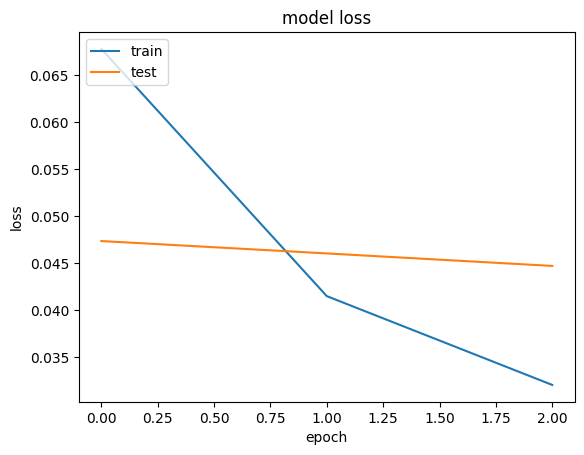

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
f = open('Dev_Numerical_Reasoning.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
df = df.astype(str)
#df = df.iloc[:200]
#df = df.iloc[100:500]
f.close()
test_data = Dataset.from_pandas(df)

In [21]:
# Try improved version
def t5_predictions(data, tokenizer, model):
    text = data['text']
    headline = data['masked headline']
    print(headline)
    inputs = tokenizer.encode_plus(text, add_special_tokens=True,
                                   return_tensors="pt").input_ids
    # input_ids = inputs['input_ids'].to(device)
    # attention_masks = inputs['attention_mask']

    outputs = model.generate(inputs,
                             max_length=128, num_beams=5, early_stopping=True)

    _0_index = headline.index('<extra_id_0> ')
    print(_0_index)

    res = ''
    results = tokenizer.decode(outputs[0][1:], skip_special_tokens=False,
                               clean_up_tokenization_spaces=False)
    print("Pred: ", results)
    #res = re.findall(r"([\d:,./]+)", results)
    res = re.findall(r"(\d+[,./]?\d*)", results[_0_index:_0_index+30])

    try:
        return res[0]
    except:
        return None

To load the ROUGE metric which stands for Recall-Oriented Understudy for Gisting Evaluation to calculates the similarity between the predicted headlines and actual headlines. ROUGE-N measures the number of matching n-grams between the model-generated text and an actual headline.



In [ ]:
tru = 0
for i in test_data:
    prediction1 = t5_predictions(i, tokenizer, model)
    answer = i['ans']
    print("Answer: ", answer)
    print("Prediction1: ", prediction1)
    print("Calc: ", i['calculation'])
    if answer == prediction1:
        tru += 1
    print("")

<extra_id_0> rd Victim Dead in Quarry Shooting; Manhunt Still On </s>


2023-10-20 15:24:14.262899: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f79cc0ab380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-20 15:24:14.262969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-10-20 15:24:14.262978: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-10-20 15:24:14.267880: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-20 15:24:14.290697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-10-20 15:24:14.298966: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation o

0
Pred:  3rd Victim Dead in Quarry Shooting; Manhunt Still On</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

NYT Corrects 1853 Piece After <extra_id_0>  Years Win </s>
30
Pred:  NYT Corrects 1853 Piece After 12 Years Win</s><pad>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Stocks Up <extra_id_0>  in Election Rally </s>
10
Pred:  Stocks Up 30 in Election Rally</s><pad>
Answer:  305
Prediction1:  30
Calc:  Round(305.45,0)

You Can Watch The Interview at <extra_id_0> pm </s>
31
Pred:  You Can Watch The Interview at 1pm</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Murder Suspect, <extra_id_0> , Will Stay in Adult Jail </s>
16
Pred:  Murder Suspect, 10, Will Stay in Adult Jail</s><pad>
Answer:  10
Prediction1:  10,
Calc:  Copy(10)

Tobacco Firms Knew of Radiation in Cigs—in <extra_id_0>  </s>
43
Pred:  Tobacco Firms Knew of Radiation in Cigs—in 1959</s>
Answer:  1959
Prediction1:  1959
Calc:  Copy(1959)

AIG Bonuses Higher Than Thought: $<extra_id_0> M </s>
34
Pred:  AIG Bonuses Hi

In [25]:
# LATEST
print(tru/len(test_data))

0.8518662519440124


It shows the ratio of the number of unigrams in R that appear also in C over the number of unigrams in R.

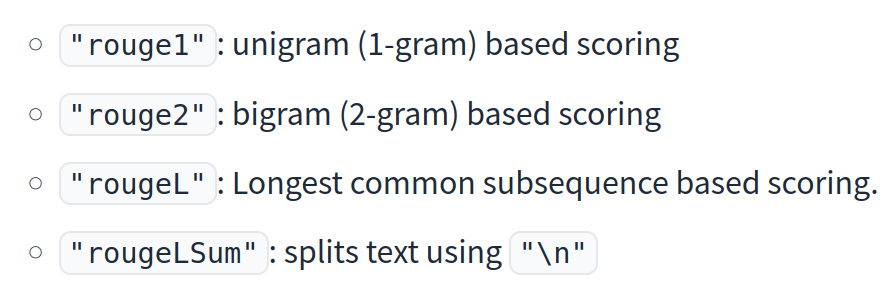

### References:
[1] Prakhar Mishra. 2020. Understanding T5 Model : Text to Text Transfer Transformer Model. Towards Data Science
https://towardsdatascience.com/understanding-t5-model-text-to-text-transfer-transformer-model-69ce4c165023.

[2] Summarization. Huggingface. https://huggingface.co/docs/transformers/tasks/summarization.

[3] Fabio Chiusano. 2022. Two minutes NLP — Learn the ROUGE metric by examples. Medium. https://medium.com/nlplanet/two-minutes-nlp-learn-the-rouge-metric-by-examples-f179cc285499.